<a href="https://colab.research.google.com/github/acse-2020/acse2020-acse9-finalreport-acse-jaq15/blob/main/notebooks/LSTM_GRU/LSTM_GRU_Corn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

The cells below handle all the necessary imports to run our models, making use of the public repo feeder_repo, linked <!-- [Text](link) -->
[here](https://github.com/acse-jaq15/feeder_repo).

In [1]:
# clone the feeder repo to get data_reader module and financial time series data
!git clone https://github.com/acse-jaq15/feeder_repo.git

Cloning into 'feeder_repo'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (142/142), done.
remote: Total 147 (delta 71), reused 6 (delta 2), pack-reused 0
Receiving objects: 100% (147/147), 120.19 KiB | 5.72 MiB/s, done.
Resolving deltas: 100% (71/71), done.


In [2]:
# using '%' to enforce a permanent change of directory
%cd feeder_repo/

/content/feeder_repo


In [3]:
# checking contents listed correctly, should read:
# baseline_model.py data data_reader.py LICENSE README.md security_plotter.py
!ls

base_model.py  data  data_reader.py  LICENSE  README.md  security_plotter.py


In [4]:
import math
import sys
import keras
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras.layers import *
from keras.utils.layer_utils import count_params
from keras.utils.vis_utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, Callback
from keras.optimizers import RMSprop, SGD, Adam, Nadam
from keras.initializers import random_normal

In [5]:
# appending path with 'feeder_repo' string
sys.path.append('feeder_repo')

# import Data_Reader class from data_reader module
from feeder_repo.data_reader import Data_Reader
# import Baseline_Model class from base_model module
from feeder_repo.base_model import Base_Model
# import Security_Plotter class from security_plotter module
from feeder_repo.security_plotter import Security_Plotter

In [6]:
# checking if the notebook is running on a GPU
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
    print('and then re-execute this cell.')
else:
    print(gpu_info)

Mon Jul 19 10:54:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Handling the data
Here the Data_Reader class is used to read the time series data and extract training, test and validation sets, along with the relevant X and y values.

In [7]:
# storing the file to be read as a string
in_str = 'Corn'
# storing the year of the time series to be used as test data
in_yr = 2019
# creating a variable to store the model name
model_str = 'LSTM_GRU'
# setting our window_length to be 30 days
window_len = 30

In [8]:
# creating an instance of Data_Reader class
in_data = Data_Reader(in_str, in_yr)
# calling class method extract_train_test to generate training and test datasets
in_data.extract_train_test()
# calling class method extract_xy to generate X and y training and test datasets
in_data.extract_xy(window_len)

# assigning X_train and y_train
X_train = in_data.X_train
y_train = in_data.y_train

# assigning X_test and y_test
X_test = in_data.X_test
y_test = in_data.y_test

# assigning X_val_train and y_val_train
X_val_train = in_data.X_val_train
y_val_train = in_data.y_val_train

# assigning X_val_test and y_val_test
X_val_test = in_data.X_val_test
y_val_test = in_data.y_val_test

# Setting up wandb itegration
Here wandb is used to perform hyperparameter tuning.

In [9]:
# installing the wandb library and importing
%pip install wandb -q
import wandb
from wandb.keras import WandbCallback

     |████████████████████████████████| 1.8MB 4.3MB/s 
     |████████████████████████████████| 143kB 42.2MB/s 
     |████████████████████████████████| 143kB 41.1MB/s 
     |████████████████████████████████| 174kB 30.3MB/s 
     |████████████████████████████████| 102kB 9.1MB/s 
     |████████████████████████████████| 71kB 7.9MB/s 
ERROR: requests 2.23.0 has requirement urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you'll have urllib3 1.26.6 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [10]:
!pip install wandb -qq

In [11]:
# logging in so the hyperparameter tunings sweeps can be saved
!wandb login

/usr/local/lib/python3.7/dist-packages/requests/__init__.py:91: RequestsDependencyWarning: urllib3 (1.26.6) or chardet (3.0.4) doesn't match a supported version!
  RequestsDependencyWarning)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [12]:
# configuring the sweep, making use of a random search methodology
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'mse',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [128, 64, 32]
        },
        'learning_rate': {
            'values': [0.005, 0.001, 0.0005]
        },
        'dropout': {
            'values': [0.1, 0.2, 0.3]
        },
        'optimizer': {
            'values': ['adam', 'nadam', 'rmsprop']
        },
        'activation': {
            'values': ['tanh', 'relu', 'selu']
        }
    }
}

In [13]:
# wandb calls this training function to run through the hyperparameter search
def train():
    # default values for searching
    config_defaults = {
        'epochs': 100,
        'batch_size': 32,
        'learning_rate': 0.005,
        'dropout': 0.2,
        'optimizer': 'adam',
        'activation': 'tanh',
        'momentum': 0.9,
        'seed': 42
    }

    # Initialize a new wandb run
    wandb.init(config=config_defaults)
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config

    # setting keras model to sequential mode
    model = Sequential()

    # layer 1
    model.add(LSTM(units=64, activation=config.activation, return_sequences=True, input_shape=(window_len, 1)))
    model.add(Dropout(config.dropout))
    # layer 2
    model.add(GRU(units=64, activation=config.activation))
    model.add(Dropout(0.1))
    # layer 3
    model.add(Dense(1))

    # Define the optimizer
    if config.optimizer=='sgd':
      optimizer = SGD(learning_rate=config.learning_rate, decay=1e-5, momentum=config.momentum, nesterov=True)
    elif config.optimizer=='rmsprop':
      optimizer = RMSprop(learning_rate=config.learning_rate, decay=1e-5)
    elif config.optimizer=='adam':
      optimizer = Adam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)
    elif config.optimizer=='nadam':
      optimizer = Nadam(learning_rate=config.learning_rate, beta_1=0.9, beta_2=0.999, clipnorm=1.0)

    model.compile(loss = "mean_squared_error", optimizer=optimizer, metrics=['mean_squared_error', 'mean_absolute_error'])

    model.fit(X_val_train, y_val_train, batch_size=config.batch_size,
              epochs=config.epochs,
              validation_data=(X_val_test, y_val_test),
              callbacks=[WandbCallback(validation_data=(X_val_test, y_val_test)),
                          EarlyStopping(patience=10, restore_best_weights=True)])

In [14]:
# setting up our sweep_id
sweep_id = wandb.sweep(sweep_config, project='ACSE_9_'+model_str)

Create sweep with ID: amj4ayh1
Sweep URL: https://wandb.ai/acse-jaq15/ACSE_9_LSTM_GRU/sweeps/amj4ayh1


In [16]:
# initialising a new sweep
wandb.agent(sweep_id, train, project='ACSE_9_'+model_str)

wandb: Agent Starting Run: jkrj1mgh with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
32/32 [==============================] - 11s 205ms/step - loss: 0.4524 - mean_squared_error: 0.4524 - mean_absolute_error: 0.3862 - val_loss: 0.0058 - val_mean_squared_error: 0.0058 - val_mean_absolute_error: 0.0597
Epoch 2/50
32/32 [==============================] - 6s 174ms/step - loss: 0.0042 - mean_squared_error: 0.0042 - mean_absolute_error: 0.0509 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0486
Epoch 3/50
32/32 [==============================] - 5s 172ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0474 - val_loss: 0.0039 - val_mean_squared_error: 0.0039 - val_mean_absolute_error: 0.0481
Epoch 4/50
32/32 [==============================] - 5s 169ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0423 - val_loss: 0.0040 - val_mean_squared_error: 0.0040 - val_mean_absolute_error: 0.0490
Epoch 5/50
32/32 [==============================] - 5s 169ms/step - loss: 0.0029 - mean_squared

epoch,49
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02854
val_loss,0.00205
val_mean_squared_error,0.00205
val_mean_absolute_error,0.03562
_runtime,285
_timestamp,1626638447
_step,49
best_val_loss,0.00187


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▅▄▄▄▃▃▃▄▃▂▃▂▄▂▂▂▄▂▂▁▁▂▁▁▂▁▂▁▃▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▅▅▄▄▄▃▃▃▄▃▂▃▂▄▂▂▂▄▂▂▁▁▂▁▁▂▁▂▁▃▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▅▅▄▄▄▄▃▄▅▃▃▃▃▄▃▂▂▄▃▂▂▂▃▁▁▂▁▂▂▃▁▁▂▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ww9egcvl with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 7s 347ms/step - loss: 0.1343 - mean_squared_error: 0.1343 - mean_absolute_error: 0.3109 - val_loss: 0.0078 - val_mean_squared_error: 0.0078 - val_mean_absolute_error: 0.0718
Epoch 2/200
8/8 [==============================] - 1s 180ms/step - loss: 0.0121 - mean_squared_error: 0.0121 - mean_absolute_error: 0.0911 - val_loss: 0.0087 - val_mean_squared_error: 0.0087 - val_mean_absolute_error: 0.0735
Epoch 3/200
8/8 [==============================] - 1s 170ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0637 - val_loss: 0.0063 - val_mean_squared_error: 0.0063 - val_mean_absolute_error: 0.0629
Epoch 4/200
8/8 [==============================] - 1s 177ms/step - loss: 0.0058 - mean_squared_error: 0.0058 - mean_absolute_error: 0.0607 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0657
Epoch 5/200
8/8 [==============================] - 1s 183ms/step - loss: 0.0050 - mean_squared_error

epoch,29
loss,0.00427
mean_squared_error,0.00427
mean_absolute_error,0.05282
val_loss,0.00397
val_mean_squared_error,0.00397
val_mean_absolute_error,0.05015
_runtime,53
_timestamp,1626638557
_step,29
best_val_loss,0.00343


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▁▁▂▁▂▂▁▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁
val_loss,▃▄▃▃▃▂▂▂▂▃▂▂▂▆▂▃▂▄▂▁█▂▁▄▂▂▁▁▁▁
val_mean_squared_error,▃▄▃▃▃▂▂▂▂▃▂▂▂▆▂▃▂▄▂▁█▂▁▄▂▂▁▁▁▁
val_mean_absolute_error,▄▄▃▃▄▃▂▃▂▃▂▃▃▇▂▄▂▄▂▁█▃▁▅▂▃▂▁▂▂
_runtime,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_timestamp,▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇██
_step,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███


wandb: Agent Starting Run: z1tvodg4 with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 11s 205ms/step - loss: 0.6192 - mean_squared_error: 0.6192 - mean_absolute_error: 0.4075 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0593
Epoch 2/200
32/32 [==============================] - 5s 171ms/step - loss: 0.0033 - mean_squared_error: 0.0033 - mean_absolute_error: 0.0447 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0478
Epoch 3/200
32/32 [==============================] - 6s 173ms/step - loss: 0.0028 - mean_squared_error: 0.0028 - mean_absolute_error: 0.0417 - val_loss: 0.0038 - val_mean_squared_error: 0.0038 - val_mean_absolute_error: 0.0482
Epoch 4/200
32/32 [==============================] - 5s 167ms/step - loss: 0.0027 - mean_squared_error: 0.0027 - mean_absolute_error: 0.0411 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0460
Epoch 5/200
32/32 [==============================] - 5s 168ms/step - loss: 0.0026 - mean_sq

epoch,51
loss,0.00149
mean_squared_error,0.00149
mean_absolute_error,0.03037
val_loss,0.00192
val_mean_squared_error,0.00192
val_mean_absolute_error,0.03412
_runtime,298
_timestamp,1626638903
_step,51
best_val_loss,0.0017


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▃▄▃▃▂▂▂▂▂▂▁▁▁▂▃▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▂▁▂▁
val_mean_squared_error,█▅▅▄▃▄▃▃▂▂▂▂▂▂▁▁▁▂▃▁▁▂▁▂▁▁▁▁▁▁▁▂▁▁▂▁▂▁▂▁
val_mean_absolute_error,█▅▅▅▄▄▃▄▃▃▂▂▂▂▂▂▂▃▃▁▁▂▁▂▂▁▁▁▁▁▂▂▁▁▃▁▂▁▃▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: ehismzwz with config:
wandb: 	activation: selu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 11s 206ms/step - loss: 0.0401 - mean_squared_error: 0.0401 - mean_absolute_error: 0.1504 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0787
Epoch 2/100
32/32 [==============================] - 5s 170ms/step - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0677 - val_loss: 0.0073 - val_mean_squared_error: 0.0073 - val_mean_absolute_error: 0.0684
Epoch 3/100
32/32 [==============================] - 5s 172ms/step - loss: 0.0061 - mean_squared_error: 0.0061 - mean_absolute_error: 0.0613 - val_loss: 0.0077 - val_mean_squared_error: 0.0077 - val_mean_absolute_error: 0.0698
Epoch 4/100
32/32 [==============================] - 6s 175ms/step - loss: 0.0044 - mean_squared_error: 0.0044 - mean_absolute_error: 0.0517 - val_loss: 0.0052 - val_mean_squared_error: 0.0052 - val_mean_absolute_error: 0.0573
Epoch 5/100
32/32 [==============================] - 6s 179ms/step - loss: 0.0040 - mean_sq

epoch,98
loss,0.00132
mean_squared_error,0.00132
mean_absolute_error,0.02839
val_loss,0.00202
val_mean_squared_error,0.00202
val_mean_absolute_error,0.03541
_runtime,574
_timestamp,1626639488
_step,98
best_val_loss,0.00179


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▃▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: tdgt2kmf with config:
wandb: 	activation: tanh
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/100
8/8 [==============================] - 6s 171ms/step - loss: 0.1320 - mean_squared_error: 0.1320 - mean_absolute_error: 0.2783 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0749
Epoch 2/100
8/8 [==============================] - 0s 14ms/step - loss: 0.0060 - mean_squared_error: 0.0060 - mean_absolute_error: 0.0628 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0760
Epoch 3/100
8/8 [==============================] - 0s 16ms/step - loss: 0.0088 - mean_squared_error: 0.0088 - mean_absolute_error: 0.0765 - val_loss: 0.0165 - val_mean_squared_error: 0.0165 - val_mean_absolute_error: 0.1085
Epoch 4/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0675 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0585
Epoch 5/100
8/8 [==============================] - 0s 15ms/step - loss: 0.0055 - mean_squared_error: 0.

epoch,99
loss,0.00207
mean_squared_error,0.00207
mean_absolute_error,0.03669
val_loss,0.00327
val_mean_squared_error,0.00327
val_mean_absolute_error,0.04628
_runtime,29
_timestamp,1626639528
_step,99
best_val_loss,0.00186


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▃▂▂▃▂▃▂▁▂▂▂▁▁▁▂▁▁▁▁▂▁▂▁▁▂▁▁▁▁▁▁▁▁▂▁▁▁▁
val_loss,▄█▃▅▃▃▂▃▂▂▂▂▂▂▂▂▃▂▂▁▁▂▁▂▁▂▃▁▁▁▁▁▁▁▁▂▂▁▁▂
val_mean_squared_error,▄█▃▅▃▃▂▃▂▂▂▂▂▂▂▂▃▂▂▁▁▂▁▂▁▂▃▁▁▁▁▁▁▁▁▂▂▁▁▂
val_mean_absolute_error,▅█▃▆▄▃▃▄▃▂▂▂▃▂▂▂▄▂▂▂▂▂▁▂▁▂▄▂▂▁▁▁▁▂▁▂▃▁▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇██████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: ahek1nqn with config:
wandb: 	activation: tanh
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam


Epoch 1/50
16/16 [==============================] - 6s 117ms/step - loss: 0.1174 - mean_squared_error: 0.1174 - mean_absolute_error: 0.2728 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0767
Epoch 2/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0662 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0733
Epoch 3/50
16/16 [==============================] - 0s 15ms/step - loss: 0.0056 - mean_squared_error: 0.0056 - mean_absolute_error: 0.0597 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0723
Epoch 4/50
16/16 [==============================] - 0s 14ms/step - loss: 0.0049 - mean_squared_error: 0.0049 - mean_absolute_error: 0.0547 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0717
Epoch 5/50
16/16 [==============================] - 0s 16ms/step - loss: 0.0048 - mean_squared_erro

epoch,49
loss,0.00209
mean_squared_error,0.00209
mean_absolute_error,0.03611
val_loss,0.00328
val_mean_squared_error,0.00328
val_mean_absolute_error,0.04483
_runtime,25
_timestamp,1626639569
_step,49
best_val_loss,0.0032


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▆▅▅▅▅▄▄▅▃▄▃▅▃▃▄▂▂▂▄▂▂▃▂▂▃▁▁▁▂▁▂▁▁▂▂▁
val_mean_squared_error,█▇▇▇▆▅▅▅▅▄▄▅▃▄▃▅▃▃▄▂▂▂▄▂▂▃▂▂▃▁▁▁▂▁▂▁▁▂▂▁
val_mean_absolute_error,█▇▇▇▆▅▅▅▅▄▅▅▃▄▃▅▃▃▄▃▂▂▅▂▂▃▂▂▃▂▂▂▂▂▂▂▁▂▂▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: k0z21ny3 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.3
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 251ms/step - loss: 0.2125 - mean_squared_error: 0.2125 - mean_absolute_error: 0.4162 - val_loss: 0.0102 - val_mean_squared_error: 0.0102 - val_mean_absolute_error: 0.0802
Epoch 2/100
16/16 [==============================] - 3s 166ms/step - loss: 0.0207 - mean_squared_error: 0.0207 - mean_absolute_error: 0.1214 - val_loss: 0.0264 - val_mean_squared_error: 0.0264 - val_mean_absolute_error: 0.1352
Epoch 3/100
16/16 [==============================] - 3s 167ms/step - loss: 0.0142 - mean_squared_error: 0.0142 - mean_absolute_error: 0.0954 - val_loss: 0.0088 - val_mean_squared_error: 0.0088 - val_mean_absolute_error: 0.0738
Epoch 4/100
16/16 [==============================] - 3s 168ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0751 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0708
Epoch 5/100
16/16 [==============================] - 3s 176ms/step - loss: 0.0067 - mean_squ

epoch,99
loss,0.00223
mean_squared_error,0.00223
mean_absolute_error,0.03709
val_loss,0.00339
val_mean_squared_error,0.00339
val_mean_absolute_error,0.04512
_runtime,292
_timestamp,1626639878
_step,99
best_val_loss,0.00304


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▂▁
val_mean_squared_error,█▇▆▆▅▅▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▂▁▁▁▁▂▁▁▁▂▁
val_mean_absolute_error,█▇▇▇▆▆▅▄▄▄▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▂▂▂▁▁▁▂▁▁▁▂▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: pldn5ujs with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/50
32/32 [==============================] - 11s 212ms/step - loss: 0.1384 - mean_squared_error: 0.1384 - mean_absolute_error: 0.2537 - val_loss: 0.0081 - val_mean_squared_error: 0.0081 - val_mean_absolute_error: 0.0733
Epoch 2/50
32/32 [==============================] - 6s 173ms/step - loss: 0.0104 - mean_squared_error: 0.0104 - mean_absolute_error: 0.0812 - val_loss: 0.0092 - val_mean_squared_error: 0.0092 - val_mean_absolute_error: 0.0790
Epoch 3/50
32/32 [==============================] - 6s 175ms/step - loss: 0.0112 - mean_squared_error: 0.0112 - mean_absolute_error: 0.0814 - val_loss: 0.0097 - val_mean_squared_error: 0.0097 - val_mean_absolute_error: 0.0792
Epoch 4/50
32/32 [==============================] - 6s 177ms/step - loss: 0.0110 - mean_squared_error: 0.0110 - mean_absolute_error: 0.0834 - val_loss: 0.0062 - val_mean_squared_error: 0.0062 - val_mean_absolute_error: 0.0634
Epoch 5/50
32/32 [==============================] - 6s 173ms/step - loss: 0.0095 - mean_squared

epoch,36
loss,0.00247
mean_squared_error,0.00247
mean_absolute_error,0.03878
val_loss,0.00309
val_mean_squared_error,0.00309
val_mean_absolute_error,0.04338
_runtime,215
_timestamp,1626640106
_step,36
best_val_loss,0.00232


epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
loss,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▃▄▄▃▂▃▃▃▄▂▅▁▂▄▁█▃▁▁▁▂▂▁▃▂▁▁▁▂▁▃▂▁▁▁▁▁
val_mean_squared_error,▃▄▄▃▂▃▃▃▄▂▅▁▂▄▁█▃▁▁▁▂▂▁▃▂▁▁▁▂▁▃▂▁▁▁▁▁
val_mean_absolute_error,▄▄▄▃▃▄▄▃▅▂▆▂▃▄▁█▃▁▁▂▃▃▂▄▂▂▁▁▃▁▄▂▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 6tm31j40 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: rmsprop


Epoch 1/100
32/32 [==============================] - 12s 217ms/step - loss: 0.1424 - mean_squared_error: 0.1424 - mean_absolute_error: 0.3104 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0776
Epoch 2/100
32/32 [==============================] - 6s 176ms/step - loss: 0.0059 - mean_squared_error: 0.0059 - mean_absolute_error: 0.0619 - val_loss: 0.0086 - val_mean_squared_error: 0.0086 - val_mean_absolute_error: 0.0743
Epoch 3/100
32/32 [==============================] - 6s 173ms/step - loss: 0.0048 - mean_squared_error: 0.0048 - mean_absolute_error: 0.0539 - val_loss: 0.0074 - val_mean_squared_error: 0.0074 - val_mean_absolute_error: 0.0698
Epoch 4/100
32/32 [==============================] - 6s 176ms/step - loss: 0.0047 - mean_squared_error: 0.0047 - mean_absolute_error: 0.0532 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0667
Epoch 5/100
32/32 [==============================] - 6s 180ms/step - loss: 0.0046 - mean_sq

epoch,99
loss,0.00171
mean_squared_error,0.00171
mean_absolute_error,0.03239
val_loss,0.00223
val_mean_squared_error,0.00223
val_mean_absolute_error,0.03718
_runtime,577
_timestamp,1626640749
_step,99
best_val_loss,0.00223


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▄▄▄▆▄▅▃▃▆▄▂▂▃▃▂▂▄▂▃▂▂▂▃▂▁▂▁▂▁▂▁▁▁▁▂▂▁▁
val_mean_squared_error,█▆▄▄▄▆▄▅▃▃▆▄▂▂▃▃▂▂▄▂▃▂▂▂▃▂▁▂▁▂▁▂▁▁▁▁▂▂▁▁
val_mean_absolute_error,█▇▅▅▄▇▄▆▃▃▆▅▃▃▃▄▂▂▄▂▃▂▂▂▄▂▁▂▁▂▂▂▁▁▁▂▃▂▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: jfkbsbwl with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/200
8/8 [==============================] - 7s 333ms/step - loss: 0.3945 - mean_squared_error: 0.3945 - mean_absolute_error: 0.4834 - val_loss: 0.0930 - val_mean_squared_error: 0.0930 - val_mean_absolute_error: 0.2900
Epoch 2/200
8/8 [==============================] - 1s 187ms/step - loss: 0.0296 - mean_squared_error: 0.0296 - mean_absolute_error: 0.1408 - val_loss: 0.0240 - val_mean_squared_error: 0.0240 - val_mean_absolute_error: 0.1368
Epoch 3/200
8/8 [==============================] - 1s 181ms/step - loss: 0.0093 - mean_squared_error: 0.0093 - mean_absolute_error: 0.0773 - val_loss: 0.0133 - val_mean_squared_error: 0.0133 - val_mean_absolute_error: 0.0971
Epoch 4/200
8/8 [==============================] - 1s 184ms/step - loss: 0.0064 - mean_squared_error: 0.0064 - mean_absolute_error: 0.0642 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0538
Epoch 5/200
8/8 [==============================] - 1s 179ms/step - loss: 0.0035 - mean_squared_error

epoch,74
loss,0.00138
mean_squared_error,0.00138
mean_absolute_error,0.02867
val_loss,0.00197
val_mean_squared_error,0.00197
val_mean_absolute_error,0.03526
_runtime,120
_timestamp,1626640882
_step,74
best_val_loss,0.00196


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qdnyhyhd with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/100
32/32 [==============================] - 6s 49ms/step - loss: 0.0757 - mean_squared_error: 0.0757 - mean_absolute_error: 0.2112 - val_loss: 0.0079 - val_mean_squared_error: 0.0079 - val_mean_absolute_error: 0.0727
Epoch 2/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0065 - mean_squared_error: 0.0065 - mean_absolute_error: 0.0651 - val_loss: 0.0069 - val_mean_squared_error: 0.0069 - val_mean_absolute_error: 0.0656
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0475 - val_loss: 0.0064 - val_mean_squared_error: 0.0064 - val_mean_absolute_error: 0.0641
Epoch 4/100
32/32 [==============================] - 0s 11ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0486 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0619
Epoch 5/100
32/32 [==============================] - 0s 12ms/step - loss: 0.0033 - mean_squared_

epoch,99
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.02631
val_loss,0.00178
val_mean_squared_error,0.00178
val_mean_absolute_error,0.03288
_runtime,52
_timestamp,1626640996
_step,99
best_val_loss,0.00164


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▅▄▄▃▃▃▄▂▄▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▅▅▄▄▃▃▃▄▂▄▂▂▂▂▂▂▂▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▄▄▄▃▄▃▄▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▂▁▂▁▁▁▁▂▁▁
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: k8m8e7go with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 50
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: adam


Epoch 1/50
8/8 [==============================] - 7s 333ms/step - loss: 0.2719 - mean_squared_error: 0.2719 - mean_absolute_error: 0.4857 - val_loss: 0.3374 - val_mean_squared_error: 0.3374 - val_mean_absolute_error: 0.5638
Epoch 2/50
8/8 [==============================] - 1s 182ms/step - loss: 0.1911 - mean_squared_error: 0.1911 - mean_absolute_error: 0.4033 - val_loss: 0.2227 - val_mean_squared_error: 0.2227 - val_mean_absolute_error: 0.4546
Epoch 3/50
8/8 [==============================] - 1s 182ms/step - loss: 0.1168 - mean_squared_error: 0.1168 - mean_absolute_error: 0.3067 - val_loss: 0.0954 - val_mean_squared_error: 0.0954 - val_mean_absolute_error: 0.2879
Epoch 4/50
8/8 [==============================] - 1s 172ms/step - loss: 0.0348 - mean_squared_error: 0.0348 - mean_absolute_error: 0.1588 - val_loss: 0.0091 - val_mean_squared_error: 0.0091 - val_mean_absolute_error: 0.0784
Epoch 5/50
8/8 [==============================] - 1s 177ms/step - loss: 0.0156 - mean_squared_error: 0.0

epoch,49
loss,0.00353
mean_squared_error,0.00353
mean_absolute_error,0.04773
val_loss,0.00523
val_mean_squared_error,0.00523
val_mean_absolute_error,0.0574
_runtime,84
_timestamp,1626641096
_step,49
best_val_loss,0.0044


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▅▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▆▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▄▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ebwkhryt with config:
wandb: 	activation: selu
wandb: 	batch_size: 64
wandb: 	dropout: 0.1
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/100
16/16 [==============================] - 8s 256ms/step - loss: 0.4830 - mean_squared_error: 0.4830 - mean_absolute_error: 0.4460 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0566
Epoch 2/100
16/16 [==============================] - 3s 193ms/step - loss: 0.0070 - mean_squared_error: 0.0070 - mean_absolute_error: 0.0669 - val_loss: 0.0061 - val_mean_squared_error: 0.0061 - val_mean_absolute_error: 0.0622
Epoch 3/100
16/16 [==============================] - 3s 176ms/step - loss: 0.0032 - mean_squared_error: 0.0032 - mean_absolute_error: 0.0443 - val_loss: 0.0036 - val_mean_squared_error: 0.0036 - val_mean_absolute_error: 0.0465
Epoch 4/100
16/16 [==============================] - 3s 169ms/step - loss: 0.0026 - mean_squared_error: 0.0026 - mean_absolute_error: 0.0396 - val_loss: 0.0035 - val_mean_squared_error: 0.0035 - val_mean_absolute_error: 0.0456
Epoch 5/100
16/16 [==============================] - 3s 181ms/step - loss: 0.0027 - mean_squ

epoch,99
loss,0.00107
mean_squared_error,0.00107
mean_absolute_error,0.02578
val_loss,0.00167
val_mean_squared_error,0.00167
val_mean_absolute_error,0.03151
_runtime,301
_timestamp,1626641434
_step,99
best_val_loss,0.00164


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁
val_mean_squared_error,█▅▅▄▄▃▃▃▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁▁▁▁▁▁
val_mean_absolute_error,█▅▆▄▄▄▃▃▃▃▂▂▃▂▂▂▂▂▃▂▁▁▁▁▁▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: 38vl9bw9 with config:
wandb: 	activation: selu
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	epochs: 100
wandb: 	learning_rate: 0.005
wandb: 	optimizer: rmsprop


Epoch 1/100
8/8 [==============================] - 7s 333ms/step - loss: 10.4620 - mean_squared_error: 10.4620 - mean_absolute_error: 1.6475 - val_loss: 0.0430 - val_mean_squared_error: 0.0430 - val_mean_absolute_error: 0.1634
Epoch 2/100
8/8 [==============================] - 2s 199ms/step - loss: 0.0347 - mean_squared_error: 0.0347 - mean_absolute_error: 0.1438 - val_loss: 0.0606 - val_mean_squared_error: 0.0606 - val_mean_absolute_error: 0.2022
Epoch 3/100
8/8 [==============================] - 1s 183ms/step - loss: 0.0357 - mean_squared_error: 0.0357 - mean_absolute_error: 0.1526 - val_loss: 0.0666 - val_mean_squared_error: 0.0666 - val_mean_absolute_error: 0.2186
Epoch 4/100
8/8 [==============================] - 1s 186ms/step - loss: 0.0336 - mean_squared_error: 0.0336 - mean_absolute_error: 0.1485 - val_loss: 0.0755 - val_mean_squared_error: 0.0755 - val_mean_absolute_error: 0.2415
Epoch 5/100
8/8 [==============================] - 1s 183ms/step - loss: 0.0455 - mean_squared_err

epoch,42
loss,0.00475
mean_squared_error,0.00475
mean_absolute_error,0.05583
val_loss,0.01012
val_mean_squared_error,0.01012
val_mean_absolute_error,0.08735
_runtime,75
_timestamp,1626641553
_step,42
best_val_loss,0.00237


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▂▁▂▁▂▁▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▄▅▅▆▃█▂█▂▄▅▂▅▁▁▂▁▁▁▁▁▁▂▁▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂
val_mean_squared_error,▄▅▅▆▃█▂█▂▄▅▂▅▁▁▂▁▁▁▁▁▁▂▁▁▂▂▂▁▂▁▂▁▁▁▁▁▁▁▂
val_mean_absolute_error,▄▅▆▆▄█▃█▃▅▆▃▆▁▁▃▁▂▂▂▁▂▂▁▂▃▃▃▂▄▁▂▁▂▁▂▁▁▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██


wandb: Agent Starting Run: jahq7dfh with config:
wandb: 	activation: tanh
wandb: 	batch_size: 32
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Epoch 1/200
32/32 [==============================] - 6s 48ms/step - loss: 0.0703 - mean_squared_error: 0.0703 - mean_absolute_error: 0.1990 - val_loss: 0.0066 - val_mean_squared_error: 0.0066 - val_mean_absolute_error: 0.0652
Epoch 2/200
32/32 [==============================] - 0s 14ms/step - loss: 0.0055 - mean_squared_error: 0.0055 - mean_absolute_error: 0.0605 - val_loss: 0.0060 - val_mean_squared_error: 0.0060 - val_mean_absolute_error: 0.0615
Epoch 3/200
32/32 [==============================] - 0s 11ms/step - loss: 0.0037 - mean_squared_error: 0.0037 - mean_absolute_error: 0.0486 - val_loss: 0.0056 - val_mean_squared_error: 0.0056 - val_mean_absolute_error: 0.0592
Epoch 4/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - mean_absolute_error: 0.0463 - val_loss: 0.0053 - val_mean_squared_error: 0.0053 - val_mean_absolute_error: 0.0572
Epoch 5/200
32/32 [==============================] - 0s 12ms/step - loss: 0.0038 - mean_squared_

epoch,102
loss,0.00112
mean_squared_error,0.00112
mean_absolute_error,0.02664
val_loss,0.00164
val_mean_squared_error,0.00164
val_mean_absolute_error,0.0311
_runtime,54
_timestamp,1626641637
_step,102
best_val_loss,0.00164


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▄▄▄▄▄▃▃▂▂▃▂▂▂▃▂▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▄▄▄▄▄▃▃▂▂▃▂▂▂▃▂▂▁▁▁▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▅▅▅▄▅▄▃▃▃▃▃▂▂▂▃▃▃▂▂▂▁▂▂▁▁▂▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: qnqgvv22 with config:
wandb: 	activation: relu
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	epochs: 50
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Epoch 1/50
16/16 [==============================] - 9s 258ms/step - loss: 0.1244 - mean_squared_error: 0.1244 - mean_absolute_error: 0.2849 - val_loss: 0.0150 - val_mean_squared_error: 0.0150 - val_mean_absolute_error: 0.0943
Epoch 2/50
16/16 [==============================] - 3s 190ms/step - loss: 0.0085 - mean_squared_error: 0.0085 - mean_absolute_error: 0.0722 - val_loss: 0.0055 - val_mean_squared_error: 0.0055 - val_mean_absolute_error: 0.0584
Epoch 3/50
16/16 [==============================] - 3s 178ms/step - loss: 0.0039 - mean_squared_error: 0.0039 - mean_absolute_error: 0.0488 - val_loss: 0.0051 - val_mean_squared_error: 0.0051 - val_mean_absolute_error: 0.0567
Epoch 4/50
16/16 [==============================] - 3s 181ms/step - loss: 0.0038 - mean_squared_error: 0.0038 - mean_absolute_error: 0.0482 - val_loss: 0.0047 - val_mean_squared_error: 0.0047 - val_mean_absolute_error: 0.0543
Epoch 5/50
16/16 [==============================] - 3s 183ms/step - loss: 0.0035 - mean_squared_

epoch,49
loss,0.00199
mean_squared_error,0.00199
mean_absolute_error,0.03485
val_loss,0.00423
val_mean_squared_error,0.00423
val_mean_absolute_error,0.05041
_runtime,159
_timestamp,1626641849
_step,49
best_val_loss,0.00269


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂
val_mean_squared_error,█▃▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▂▁▂▂▁▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁▁▂
val_mean_absolute_error,█▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▃▂▂▂▁▁▁▂▁▁▁▁▂▂▁▂▁▁▁▁▂▁▂
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███


wandb: Agent Starting Run: 0s6tx62x with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.0005
wandb: 	optimizer: nadam


Epoch 1/200
8/8 [==============================] - 7s 352ms/step - loss: 0.2647 - mean_squared_error: 0.2647 - mean_absolute_error: 0.4784 - val_loss: 0.3504 - val_mean_squared_error: 0.3504 - val_mean_absolute_error: 0.5744
Epoch 2/200
8/8 [==============================] - 1s 183ms/step - loss: 0.1993 - mean_squared_error: 0.1993 - mean_absolute_error: 0.4102 - val_loss: 0.2215 - val_mean_squared_error: 0.2215 - val_mean_absolute_error: 0.4520
Epoch 3/200
8/8 [==============================] - 1s 182ms/step - loss: 0.1088 - mean_squared_error: 0.1088 - mean_absolute_error: 0.2930 - val_loss: 0.0565 - val_mean_squared_error: 0.0565 - val_mean_absolute_error: 0.2116
Epoch 4/200
8/8 [==============================] - 1s 179ms/step - loss: 0.0200 - mean_squared_error: 0.0200 - mean_absolute_error: 0.1159 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0812
Epoch 5/200
8/8 [==============================] - 1s 182ms/step - loss: 0.0091 - mean_squared_error

epoch,72
loss,0.00337
mean_squared_error,0.00337
mean_absolute_error,0.04638
val_loss,0.00494
val_mean_squared_error,0.00494
val_mean_absolute_error,0.05566
_runtime,122
_timestamp,1626641985
_step,72
best_val_loss,0.00481


epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Agent Starting Run: levvg7ay with config:
wandb: 	activation: relu
wandb: 	batch_size: 128
wandb: 	dropout: 0.1
wandb: 	epochs: 200
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop


Epoch 1/200
8/8 [==============================] - 7s 337ms/step - loss: 0.1394 - mean_squared_error: 0.1394 - mean_absolute_error: 0.3169 - val_loss: 0.0105 - val_mean_squared_error: 0.0105 - val_mean_absolute_error: 0.0815
Epoch 2/200
8/8 [==============================] - 2s 200ms/step - loss: 0.0078 - mean_squared_error: 0.0078 - mean_absolute_error: 0.0704 - val_loss: 0.0178 - val_mean_squared_error: 0.0178 - val_mean_absolute_error: 0.1100
Epoch 3/200
8/8 [==============================] - 2s 205ms/step - loss: 0.0082 - mean_squared_error: 0.0082 - mean_absolute_error: 0.0736 - val_loss: 0.0084 - val_mean_squared_error: 0.0084 - val_mean_absolute_error: 0.0744
Epoch 4/200
8/8 [==============================] - 1s 176ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - mean_absolute_error: 0.0719 - val_loss: 0.0075 - val_mean_squared_error: 0.0075 - val_mean_absolute_error: 0.0701
Epoch 5/200
8/8 [==============================] - 2s 203ms/step - loss: 0.0050 - mean_squared_error

epoch,110
loss,0.00284
mean_squared_error,0.00284
mean_absolute_error,0.04238
val_loss,0.00394
val_mean_squared_error,0.00394
val_mean_absolute_error,0.04913
_runtime,177
_timestamp,1626642178
_step,110
best_val_loss,0.0025


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▇▅▄▄▄▄▃▃▂▂▂▄▂▃▅▇▂▂▃▃▂▂▂▁▁▂▁▁▂▁▁▁▃▁▂▂▂▂
val_mean_squared_error,█▆▇▅▄▄▄▄▃▃▂▂▂▄▂▃▅▇▂▂▃▃▂▂▂▁▁▂▁▁▂▁▁▁▃▁▂▂▂▂
val_mean_absolute_error,█▇▇▆▄▄▄▅▃▃▃▂▂▄▂▃▇▇▃▃▃▄▂▂▂▁▁▂▁▁▂▁▁▁▄▁▃▂▂▂
_runtime,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: Sweep Agent: Waiting for job.
500 response executing GraphQL.
{"errors":[{"message":"Post \"http://anaconda.default.svc.cluster.local/search\": context deadline exceeded","path":["agentHeartbeat"]}],"data":{"agentHeartbeat":null}}
wandb: ERROR Error while calling W&B API: Post "http://anaconda.default.svc.cluster.local/search": context deadline exceeded (<Response [500]>)
wandb: Job received.
wandb: Agent Starting Run: dbosu691 with config:
wandb: 	activation: relu
wandb: 	batch_size: 32
wandb: 	dropout: 0.3
wandb: 	epochs: 200
wandb: 	learning_rate: 0.005
wandb: 	optimizer: nadam


Epoch 1/200
32/32 [==============================] - 12s 215ms/step - loss: 0.0408 - mean_squared_error: 0.0408 - mean_absolute_error: 0.1433 - val_loss: 0.0071 - val_mean_squared_error: 0.0071 - val_mean_absolute_error: 0.0665
Epoch 2/200
32/32 [==============================] - 6s 186ms/step - loss: 0.0071 - mean_squared_error: 0.0071 - mean_absolute_error: 0.0657 - val_loss: 0.0080 - val_mean_squared_error: 0.0080 - val_mean_absolute_error: 0.0710
Epoch 3/200
32/32 [==============================] - 6s 182ms/step - loss: 0.0054 - mean_squared_error: 0.0054 - mean_absolute_error: 0.0576 - val_loss: 0.0253 - val_mean_squared_error: 0.0253 - val_mean_absolute_error: 0.1380
Epoch 4/200
32/32 [==============================] - 6s 181ms/step - loss: 0.0067 - mean_squared_error: 0.0067 - mean_absolute_error: 0.0636 - val_loss: 0.0096 - val_mean_squared_error: 0.0096 - val_mean_absolute_error: 0.0815
Epoch 5/200
32/32 [==============================] - 6s 185ms/step - loss: 0.0052 - mean_sq

wandb: Ctrl + C detected. Stopping sweep.


# Setting up the best model
Using the best values from the hyperparamter search with wandb, the most optimal model configuration is used.

In [15]:
# picking the best values
best_config = {
    'epochs': 100,
    'batch_size': 32,
    'learning_rate': 0.005,
    'dropout': 0.1,
    'optimizer': 'nadam',
    'activation': 'tanh'
}

In [16]:
# clearing the settings on the keras backend
keras.backend.clear_session()

# setting keras model to sequential mode
model = Sequential()

# layer 1
model.add(LSTM(units=64, activation=best_config['activation'], return_sequences=True, input_shape=(window_len, 1)))
model.add(Dropout(best_config['dropout']))
# layer 2
model.add(GRU(units=64, activation=best_config['activation']))
model.add(Dropout(0.1))
# layer 3
model.add(Dense(1))

# defining the optimiser
if best_config['optimizer'] == 'sgd':
  optimizer = SGD(learning_rate=best_config['learning_rate'], decay=1e-5, momentum=0.9, nesterov=True)
elif best_config['optimizer'] == 'rmsprop':
  optimizer = RMSprop(learning_rate=best_config['learning_rate'], decay=1e-5)
elif best_config['optimizer'] == 'adam':
  optimizer = Adam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)
elif best_config['optimizer'] == 'nadam':
  optimizer = Nadam(learning_rate=best_config['learning_rate'], beta_1=0.9, beta_2=0.999, clipnorm=1.0)

# compile the model
model.compile(optimizer, loss='mean_squared_error')

# counting the number of trainable parameters
trainable_count = count_params(model.trainable_weights)
print('Total number of trainable parameters: ', trainable_count)

Total number of trainable parameters:  41921


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            16896     
_________________________________________________________________
dropout (Dropout)            (None, 30, 64)            0         
_________________________________________________________________
gru (GRU)                    (None, 64)                24960     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 41,921
Trainable params: 41,921
Non-trainable params: 0
_________________________________________________________________


In [18]:
# fitting the model to the training dataset
model.fit(X_train, y_train, epochs=best_config['epochs'], batch_size=best_config['batch_size'])

Epoch 1/100
39/39 [==============================] - 14s 7ms/step - loss: 0.0219
Epoch 2/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0027
Epoch 3/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0042
Epoch 4/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0022
Epoch 5/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0020
Epoch 6/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0023
Epoch 7/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 8/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0016
Epoch 9/100
39/39 [==============================] - 0s 7ms/step - loss: 0.0015
Epoch 10/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0018
Epoch 11/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0015
Epoch 12/100
39/39 [==============================] - 0s 8ms/step - loss: 0.0023
Epoch 13/100
39/39 [================

In [19]:
# creating an instance of Baseline_Model class using X_test
base_model = Base_Model(X_test, window_len)
# calling predict_y method
base_model.predict_y(in_data.test_len - window_len)

# using the model to predict y from X_test
y_pred = model.predict(X_test)
# assigning y_dummy variable to .y_pred class attribute
y_dummy = base_model.y_pred

# calling class method extract_real_price to generate unnormalised prices
in_data.extract_real_prices(y_pred, y_dummy)

# assinging y_true variable
y_true = in_data.y_true

# assigning actual_price, predicted_price and dummy_price
actual_price = in_data.actual_price
predicted_price = in_data.predicted_price
dummy_price = in_data.dummy_price

# Plotting the prediction results and getting errors
The cells below plot the actual, predicted and dummy prices using the Security_Plotter class before finally saving the model and plot.

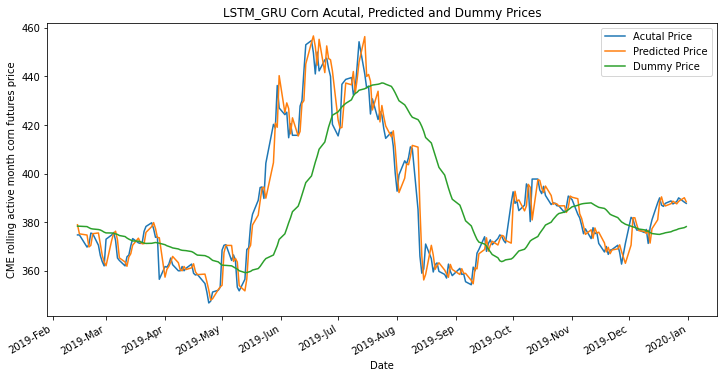

In [20]:
plotter = Security_Plotter(in_data, actual_price, predicted_price,
                            dummy_price, in_data.train_len, window_len, in_str, model_str)

plotter.single_plot()

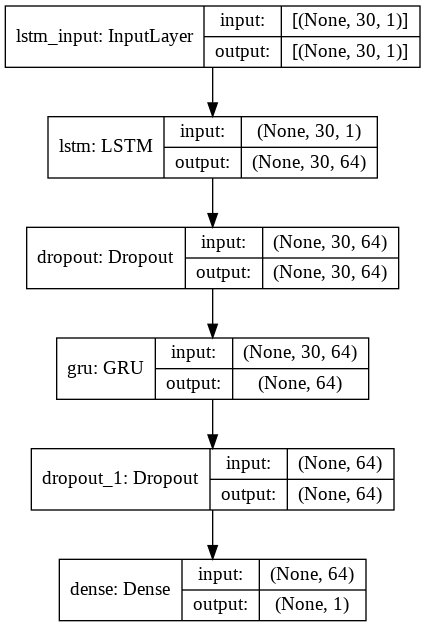

In [21]:
plot_model(model, show_shapes=True, expand_nested=True)

In [22]:
# calculating mean squared error
mse = mean_squared_error(y_true, y_pred)
d_mse = mean_squared_error(y_true, y_dummy)

# calculating root mean squared error
rmse = mean_squared_error(y_true, y_pred, squared=False)
d_rmse = mean_squared_error(y_true, y_dummy, squared=False)

# calculating mean absolute error
mae = mean_absolute_error(y_true, y_pred)
d_mae = mean_absolute_error(y_true, y_dummy)

print('MSE: ', mse)
print('RMSE: ', rmse)
print('MAE: ', mae)
print('Dummy MSE: ', d_mse)
print('Dummy RMSE: ', d_rmse)
print('Dummy MAE: ', d_mae)

MSE:  0.003416574009912131
RMSE:  0.058451467132246825
MAE:  0.041209567070981855
Dummy MSE:  0.041446864361575214
Dummy RMSE:  0.20358502980714277
Dummy MAE:  0.15160472972972977


In [23]:
# creating a string to save the model based on model name
save_path = '/content/gdrive/My Drive/models/'+model_str+'_'+in_str+'/'
# mounting google drive for easy storage of model
from google.colab import drive
# mounting the drive
drive.mount('/content/gdrive/')
# making the relevant directory to store the model
os.mkdir(save_path)
# saving the model
keras.models.save_model(model, save_path)
# saving the model graph
model_graph = plot_model(model, to_file=save_path+model_str+'_'+in_str+'_graph_.png', show_shapes=True, expand_nested=True)
# saving the matplotlib plot
plotter.fig.savefig(save_path+model_str+'_'+in_str+'_plot.png', bbox_inches='tight')
# saving the error metrics as a text file
error_file = open(save_path+model_str+'_'+in_str+'_metrics.txt', 'w+')
error_file.write('MSE: '+str(mse)+'\n'+'RMSE: '+str(rmse)+'\n'+'MAE: '+str(mae)+'\n'+
                 'Dummy MSE: '+str(d_mse)+'\n'+'Dummy RMSE: '+str(d_rmse)+'\n'+'Dummy MAE: '+str(d_mae))
error_file.close()

Mounted at /content/gdrive/


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_Corn/assets


INFO:tensorflow:Assets written to: /content/gdrive/My Drive/models/LSTM_GRU_Corn/assets
